<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Neural_Nets_the_Old_Fashioned_Way.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Neural Networks the Old Fashioned Way
This experiment implements the math of a basic 3-layer neural network and compares to results from logistic regression (and other classifiers in the future). I plan to show this on two different datasets initially and maybe grow this into real datasets (iris, boston, etc.)

This assumes familiarity with basic Calculus and Machine Learning concepts, e.g. subjects like classification, regularization, gradient descent, and training of neural nets. 

What is the objective of implementation of neural nets "from scratch"? Even if you plan on using Neural Network libraries like Tensorflow,/Keras, PyTorch, or Caffe in the future, implementing a network from scratch at least once is an extremely valuable exercise. It helps you gain an understanding of how neural networks work, and that is essential to designing effective models.

One thing to note is that the code examples here aren't intended to be efficient. They are meant to be easy to understand. 

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from sklearn.linear_model import LogisticRegression
from __future__ import division

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Below, generate a dataset to use in the classification exercises. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators, so we don't need to write the code ourselves. I'm using the scikit-learn [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.  This function will creat two overlapping "half-moons".  This is a good dataset to show the limitations of linear methods (like logistic regression).

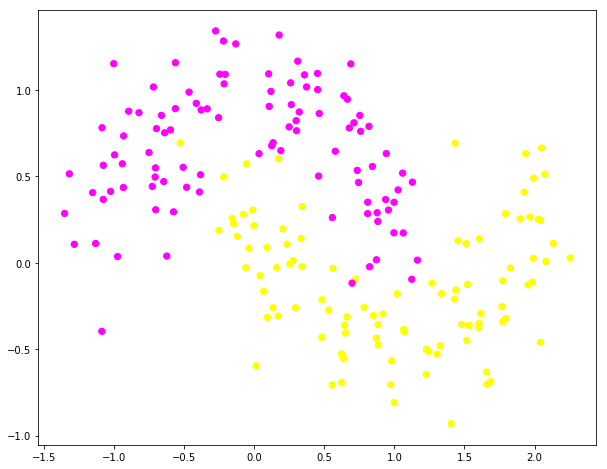

In [0]:
# Generate a dataset and plot it
np.random.seed(0)
# X is the two dimensional array of data and y is the classification (purple or yellow)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.spring)

Below I'm generating a second dataset to test with.  This uses sklearn's "make_circles" dataset.  You can see below what it does.  

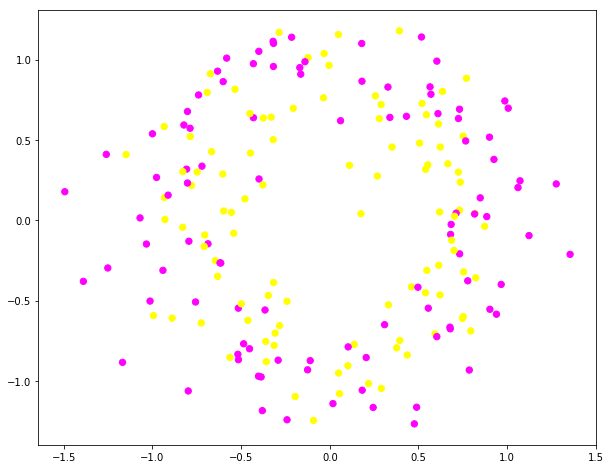

In [0]:
# Generate a dataset and plot it
np.random.seed(0)
Xc, yc = sklearn.datasets.make_circles(200, noise=0.20)
plt.scatter(Xc[:,0], Xc[:,1], s=40, c=yc, cmap=plt.cm.spring)

Both datasets we generated have two classes, plotted as magenta and yellow points. You can think of the magenta dots as male patients and the yellow dots as female patients, with the x- and y- axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class (male of female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

Through this exercise, I'm hoping to demonstrate one of the major advantages of Neural Networks. One doesn't need to invest great amounts of valuable time into [feature engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). The hidden layer of a neural network will learn features for you.

## Logistic Regression

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). To make our life easy we use the Logistic Regression class from `scikit-learn`.

In [0]:
# Train the logistic rgeression classifier on the moon dataset
model = sklearn.linear_model.LogisticRegression(solver='lbfgs')
model.fit(X, y)
prediction = model.predict(X)
percent_correct_moon = 100*np.sum(y==prediction)/y.shape[0]
print ("Percent Correctly Classified", percent_correct_moon)

Percent Correctly Classified 84.0


In [0]:
# Train the logistic rgeression classifier on the circular dataset
model_circle = sklearn.linear_model.LogisticRegression(solver='lbfgs')
model_circle.fit(Xc, yc)
# Below is where we calculate our prediction (see a2 in the neural nets section)
prediction = model_circle.predict(Xc)
# When the true label for the data (male/female) is what we predicted, we were successful.
# Use this to determine the total percentage of the time that we were successful.
percent_correct_circle = 100*np.sum(yc==prediction)/yc.shape[0]
print ("Percent Correctly Classified", percent_correct_circle)

Percent Correctly Classified 50.5


In [0]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.winter)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.spring)

Text(0.5,1,'Logistic Regression on the moon dataset \nPercent Correct Classification: 84.0')

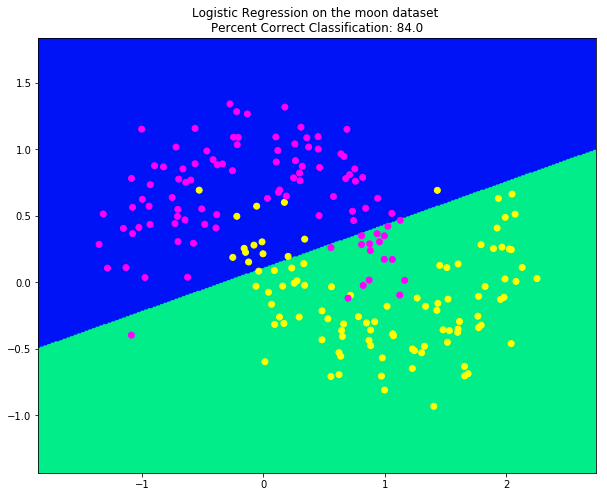

In [0]:
# Plot the decision boundary for the moon dataset
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Logistic Regression on the moon dataset \nPercent Correct Classification: %s" 
          % (percent_correct_moon))

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

Text(0.5,1,'Logistic Regression on the circular dataset \nPercent Correct Classification: 50.5')

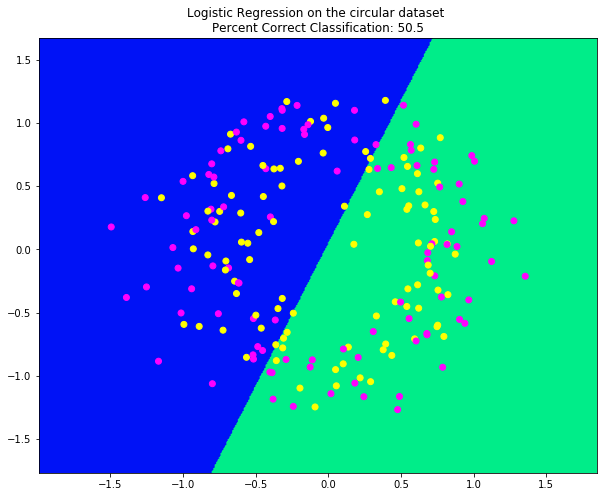

In [0]:
# Plot the decision boundary for the moon dataset
plot_decision_boundary(lambda x: model_circle.predict(x), Xc, yc)
plt.title("Logistic Regression on the circular dataset \nPercent Correct Classification: %s" 
          % percent_correct_circle)

Note above how much worse the linear classifier works on the circular dataset.  This is barely a classifer at all.  You might have easily imagined that a linear classifier on circular data would only be able to achieve 50% classification. 

## Training a Neural Network

In this exercise, we'll build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data (two). Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). 

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. 

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science. We will play with the number of nodes in the hidden later later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common choices for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). Here, I'll use `tanh`, which does well in many scenarios. A nice property of these functions is that their derivative can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because we can compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Since our goal is to find the parameters that minimize our loss function, we need to use use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. To save time, I'm only implementing a very simple version of gradient descent which is called batch gradient descent.  This approach has a fixed learning rate, unlike many of the better performing methods out there. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. This would be an excellent exercise to extend this tutorial.  I'd suggest exploring how to [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the *backpropagation algorithm*, which is a way to efficiently calculate the gradients going backwards, starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.  I'd also like to credit the Andrew Ng's excellent Stanford tutorial (http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/) for much of this explanation and math.

Applying the backpropagation formula the math looks like the below:

$$
\begin{aligned}
& \delta_3 = y - \hat{y} \\
& \delta_2 = (1 - \tanh^2z_2) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta2 \\
\end{aligned}
$$

## Implementation

Below are the variables and parameters we'd use for gradient descent:

In [0]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

## Loss Function

Here we implement the loss function we defined above. We use this to evaluate how well our model is doing.  $ y_{n,i}$  is the predicted probability value for class i and $\hat{y}$ is the true probability for that class.  Here we're doing a sum across all the data and a second sum across all the classes.

Here's the math again for cross-entropy loss:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



In [0]:
""" Loss function (cross-entropy) for the dataset."""

def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions (yhat from the formula above)
    z1 = X.dot(W1) + b1     # LAYER 1 Input
    a1 = np.tanh(z1)        # LAYER 1 Output
    z2 = a1.dot(W2) + b2    # Layer 2 Input
    exp_scores = np.exp(z2) # e^z^2
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # This is our prediction
    
    # Calculating the loss
    logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(logprobs) # Using cross-entropy loss
    
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

## Inference

This is our inference function that will calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

Here's the math again:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

In [0]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    print ("Probs: %s" % probs[199])
    return np.argmax(probs, axis=1) # Softmax - a2.  Maximum probability

## Optimization

Now for the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

Here's the math for batch gradient descent again:

$$
\begin{aligned}
& \delta_3 = y - \hat{y} \\
& \delta_2 = (1 - \tanh^2z_2) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta2 \\
\end{aligned}
$$

In [0]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_epochs: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, X, y, num_epochs=10000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is the weights and biases that we will build and return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_epochs):

        # Forward propagation
        z1 = X.dot(W1) + b1     # Affine transformation on Input layer
        a1 = np.tanh(z1)        # tanh activation function
        z2 = a1.dot(W2) + b2    # Output Layer
        # Softmax Classifier
        exp_scores = np.exp(z2) 
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs # start with forward flow
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update.  Adjust here to add decaying learning
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print ("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069033
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Probs: [0.00163893 0.99836107]


Text(0.5,1,'Decision Boundary for hidden layer size 3 with Moon Dataset')

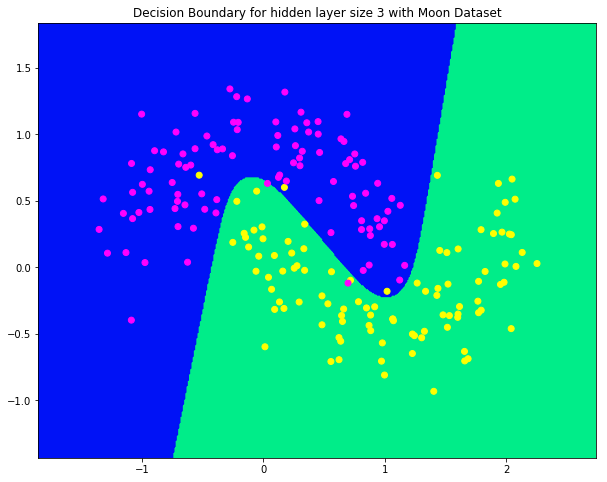

In [0]:
# Build a neural model with a hidden layer with 3 nodes

model = build_model(3, X, y, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X, y)
plt.title("Decision Boundary for hidden layer size 3 with Moon Dataset")

Our neural networks was able to find a decision boundary that successfully separates the classes.  Compare to the Linear model...

Loss after iteration 0: 0.653149
Loss after iteration 1000: 1.149138
Loss after iteration 2000: 1.145665
Loss after iteration 3000: 1.145441
Loss after iteration 4000: 1.145425
Loss after iteration 5000: 1.145423
Loss after iteration 6000: 1.145422
Loss after iteration 7000: 1.145421
Loss after iteration 8000: 1.145420
Loss after iteration 9000: 1.145420
Probs: [0.56936043 0.43063957]


Text(0.5,1,'Decision Boundary for hidden layer size 3 on the Circle Dataset')

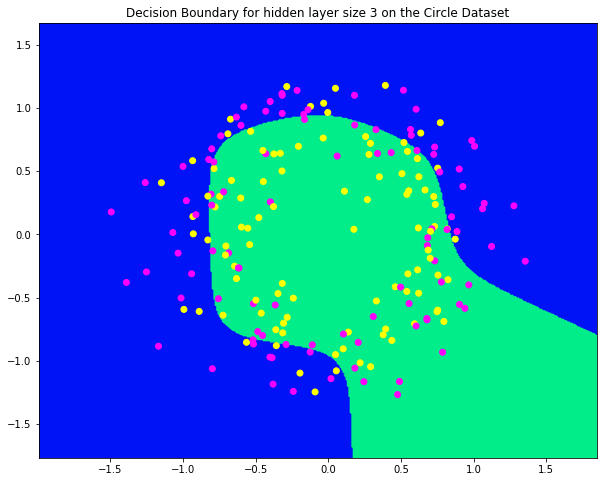

In [0]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, Xc, yc, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), Xc, yc)
plt.title("Decision Boundary for hidden layer size 3 on the Circle Dataset")

This looks interesting.  The neural model might be a better approach for this hard dataset.

# Varying the hidden layer size

Now I'm interested in seeing how varying size of the hidden layer changes the ability of the network to classify the moon dataset.  I predict that as we increse the number of layers, we'll see overfitting of the decision boundaries.
Interesting experiment.  Conduct this exercise with a second hidden layer and optimize.  This would require changes to the way we train.


Probs: [0.05175177 0.94824823]
Probs: [1.19911138e-09 9.99999999e-01]
Probs: [0.00163893 0.99836107]
Probs: [0.0038473 0.9961527]
Probs: [6.71692185e-04 9.99328308e-01]
Probs: [3.25976491e-08 9.99999967e-01]
Probs: [8.69492938e-11 1.00000000e+00]


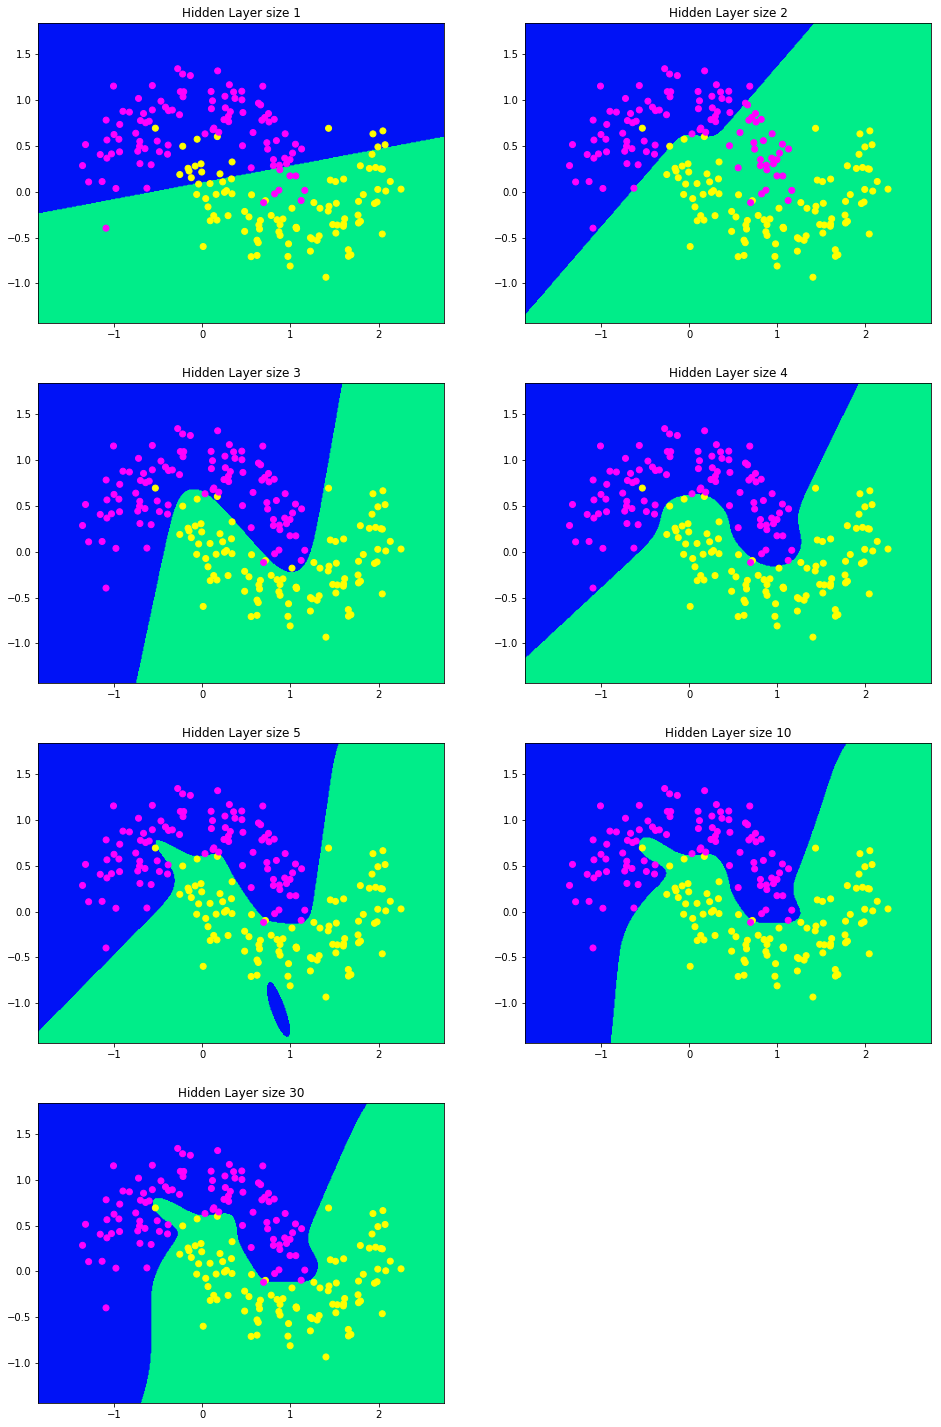

In [0]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10, 30]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim, X, y)
    plot_decision_boundary(lambda x: predict(model, x), X, y)
plt.show()

Probs: [0.47820194 0.52179806]
Probs: [0.31202921 0.68797079]
Probs: [0.56936043 0.43063957]
Probs: [0.63992018 0.36007982]
Probs: [0.90806152 0.09193848]
Probs: [0.58035613 0.41964387]
Probs: [0.674678 0.325322]


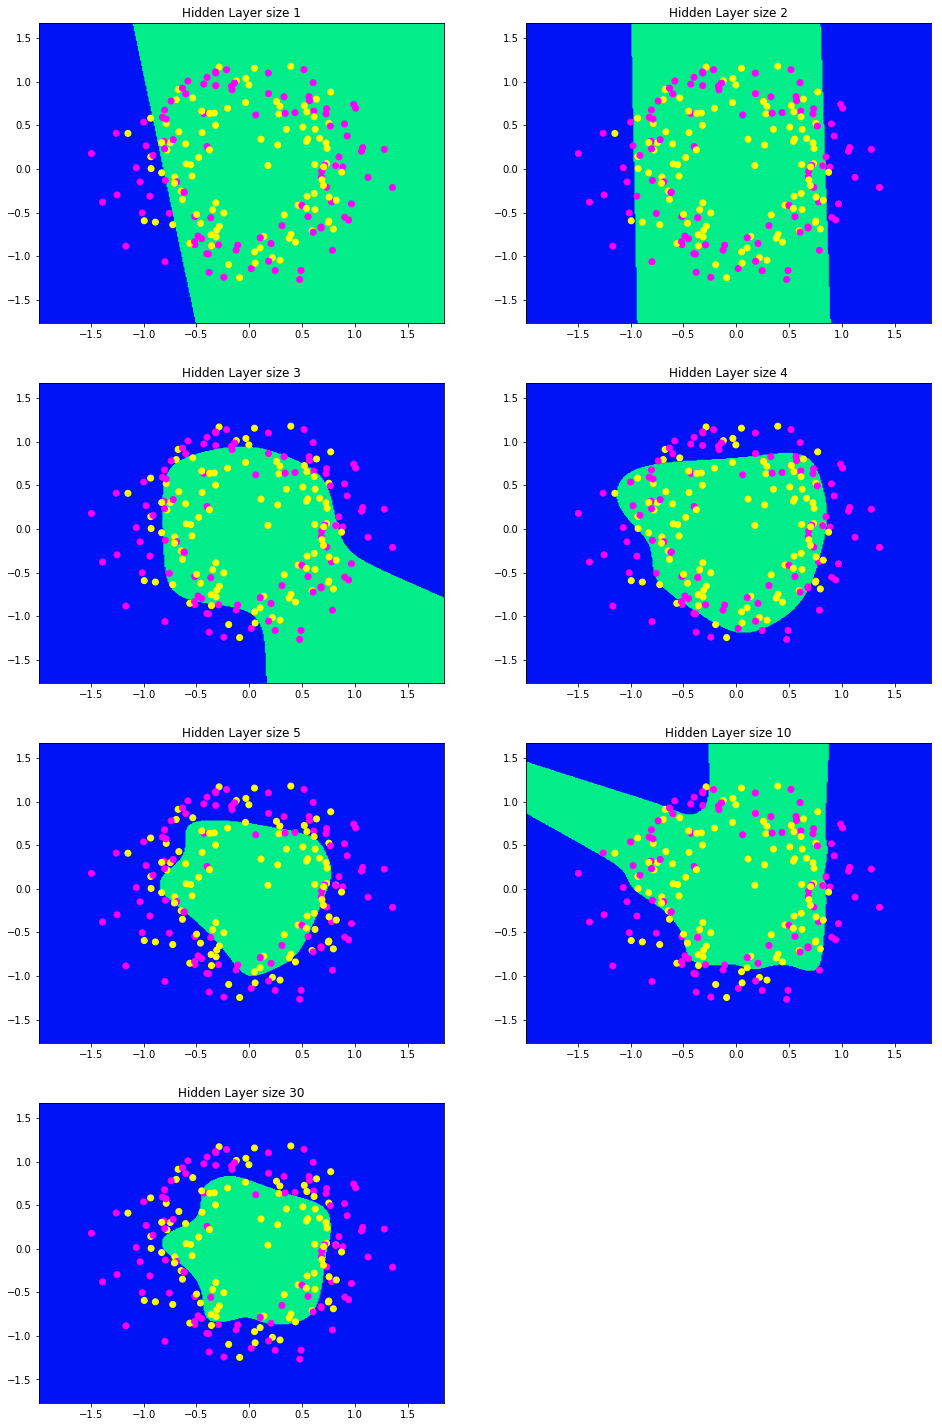

In [0]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 10, 30]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim, Xc, yc)
    plot_decision_boundary(lambda x: predict(model, x), Xc, yc)
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting (note the weird decision boundary shapes). The network size of 10 vs. 30 is basically undistinguishable.  They are "memorizing" the data as opposed to fitting the general shape. The networks with the smaller hidden layer sizes generalize better. Size of four seems optimal in my view.  There are methods to counteract overfitting (i.e., stronger regularization), but it is more effective to select a more optimal network size first.